# Estimation of the calibration factor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting
import pymc3 as pm
import pandas as pd
import scipy.stats
import mscl_utils as mscl
mscl.set_plotting_style()
%matplotlib inline
bokeh.io.output_notebook()

Loading BokehJS ...

## Counting by fluctuations 

Imagine that we have a cell that has a fixed number of fluorescent proteins (meaning that the production rate is 0). As this cell divides, these proteins will be partitioned to one of the two daughter cells in a binomial  fastion.  By exmining the difference in fluorescence between the two daughters, we can determine just how "bright" a single molecule should be. 

We can begin by positing that the fluorescence is conserved (production and degradation rates are 0). Mathematically, we can say that 

$$
I_\text{tot} = I_1 + I_2 \tag{1}
$$

where $I_\text{tot}$ is the total fluorescence of the mother cell and $I_1$ and $I_2$ are the intensities of the two daugher cells. As we know this fluorescence comes from a mix of the background fluorescence and the fluorescence of the proteins themselves, we can write that the total intensitiy of the mother cell should be proportional to the total number of proteins $N_\text{tot}$,

$$
I_\text{tot} = \alpha N_\text{tot}, \tag{2}
$$

assuming (for now) that the background fluorescence and the error in our measurement is zero. Assuming that there is a single fluroescence calibration factor and that it has the same value from cell to cell, we can write Eq. 2 for the daughter cells as

$$
I_1 = \alpha N_1\,\, ; \,\, I_2 = \alpha N_2  \tag{3, 4}
$$

which follows the assumption that the protein copy number is conserved as well,

$$
N_\text{tot} = N_1 + N_2 \tag{5}.
$$

When a cell divides, the distribution of the proteins into the two daughter cells is binomial with a partitioning probability $p$,

$$
P(n \, \vert \, N_\text{tot}) = {N_\text{tot}! \over n! (N_\text{tot} - n)!} p^{n}(1 - p)^{N_\text{tot} - n}, \tag{6}
$$

Where we've generalized $N_1$ or $N_2$ as $n$. To examine how the proteins were partitioned amongst the daughter cells, we can look at how different the intensities are between them and relate it to the total intensity of the mother as 

$$
\langle(I_1 - I_2)^2\rangle = \langle (2I_1 - I_\text{tot})^2 \tag{7}
$$

which we can translate to protein copy numbers as 

$$
\langle(I_1 - I_2)^2\rangle = \langle\left(2\alpha N_1 - \alpha N_\text{tot}\right)^2\rangle. \tag{8}
$$

As we are discussing averages in this context, we can examine this more generally as

$$
\langle(I_1 - I_2)^2 \rangle = \alpha(2\langle n \rangle - N_\text{tot})^2 \tag{9}
$$

To finish our calculation, we will have to know the mean and variance of the protein copy number upon division. 





While these two moments of the Binomial distribution are well know, it's useful to derive them explicitly. The mean can be calculated as

$$
\langle n \rangle = \sum\limits_{n = 0}^{N_\text{tot}}n{{N_\text{tot}}\choose{n}}p^{n}(1-p)^{N_\text{tot} - n}. \tag{10}
$$

This can be simplified by realizing that

$$
n {N_\text{tot}! \over n!(N_\text{tot} - n)!} = {N_\text{tot}! \over (n-1)!(N_\text{tot} - n)!} = {N_\text{tot}(N_\text{tot} - 1)! \over (n - 1)!(N_\text{tot} - n)!} \tag{11}
$$

We can now rewrite Eq. 10 as

$$
\langle n \rangle = N_\text{tot} p \sum\limits_{n= 1}^{N_\text{tot}}{{N_\text{tot} - 1}\choose{n - 1}}p^{n - 1}(1 - p)^{N_\text{tot} - n + 1} \tag{12}
$$

By defining $\nu = N_\text{tot} - 1$ and $k = n - 1$, we yield. 

$$
\begin{align}
\langle n \rangle &= N_\text{tot} p \overbrace{\sum\limits_{k= 0}^{\nu}{{\nu}\choose{k}}p^k(1 - p)^{\nu - k}}^\text{Normalized}\\
&= N_\text{tot} p \tag{13}
\end{align}
$$

which is what we would naïvely expect. With this in hand, we can naïvely solve for the variance. We can solve for $\langle n^2 \rangle$ as we did above by realizing 

$$
\langle n^2 \rangle = N_\text{tot}p\sum\limits_{n=1}^{N_\text{tot}}n{{N_\text{tot} - 1}\choose{n -1}}p^{n-1}(1 - p)^{N_\text{tot} - n} = N_\text{tot}p\sum\limits_{j=0}^\nu(j + 1){{\nu}\choose{j}}p^j(1-p)^{\nu - j}  \tag{14},
$$

where we pull the same trick of reparameterizing Eq. 13 for $\nu = N_\text{tot} - 1$ and $j = n - 1$. Simplifying Eq. 14 generates 

$$
\langle n^2 \rangle = (N_\text{tot}p)^2 - N_\text{tot}p(1 - p) \tag{15}
$$

allowing us to express the variance $\sigma^2$ as 

$$
\sigma^2 = \langle n^2 \rangle - \langle n \rangle^2 = N_\text{tot}p(1 - p). \tag{16}
$$



We can make our calculation a bit less verbose aby assuming that partitioning of the proteins is always fair such that $p = 0.5$. This means our mean and variance can be more simply written as 

$$
\langle n \rangle = {N_\text{tot} \over 2}\, ; \, \langle n^2 \rangle= {N_\text{tot}+ N_\text{tot}^2 \over 4}. \tag{17, 18}
$$

We can now return to Eq. 9 and include the mean copy number,

$$
\begin{align}
\langle (I_1 - I_2)^2 \rangle &= 4\alpha^2(\langle n^2 \rangle - \langle n \rangle N_\text{tot}) + (\alpha N_\text{tot})^2\\
& = 4\alpha^2\left({N_\text{tot} + N_\text{tot}^2 \over 4} - {2N_\text{tot}^2 \over 4}\right) + \alpha^2N_\text{tot}^2 \tag{19}.
\end{align}
$$

Some simplification brings us to our result, 

$$
\langle (I_1 - I_2)^2 \rangle = \alpha^2 N_\text{tot} = \alpha I_\text{tot}. \tag{20}
$$
 
This result tells us that the squared difference in the intensity between any two daughter cells should be linearly related to the intensity of the mother cell with a slope of the calibration factor $\alpha$. While this is a very beautiful result, our measurement is a bit more difficult.

## Inferring the calibration factor 

Wile we were rewarded for our mathematical efforts with Eq. 20, the practical use of this theoretical prediction is a bit more complicated. Primarily, we must be able to incoporate our error in the measurement of the single cell intensities. This means that our Eq. 20 becomes. 

$$
\langle (I_1 - I_2)^2 \rangle = \alpha_0 + \alpha * I_tot + \epsilon
$$

where $\alpha_0$ is the background fluorescence of our sample and $\epsilon$ is our measurement error. 


In [Rosenfeld et al. 2005]() and [Brewster et al. 2014](), the calibration factor was determined by binning the observed data and then fitting the prediction to the mean. While this is an acceptable approach, choosing the appropriate bin width is difficult and can bias the results. A more robust approach would be to write a heirarchical model which models each cell division event individually and estimate a hyperparameter for the calibration factor. 

To ensure that this type of inference is appropriate, we will generate a fake data set in which the calibration factor and the background fluorescence is known *a priori*.

In [84]:
# Set the parameters to generate the data set.
n_cells = 300
max_proteins = 700
sigma = 10
alpha = np.random.normal(50, sigma)
alpha_0 = np.random.normal(4, 3)

# Set the parent protein copy numbers and partition into children.
n_tot = (np.random.rand(n_cells) * max_proteins).astype(int) 
n_1 = np.random.binomial(n_tot, p=0.5)
n_2 = n_tot - n_1

# Compute the intensities.
I_1 = alpha_0 + alpha * n_1
I_2 = alpha_0 + alpha * n_2
I_tot = alpha_0 + alpha * n_tot
I_tot_range = np.logspace(1, 4.5, 300)

# Make it a DataFrame.
df = pd.DataFrame(np.array([n_tot, n_1, n_2, I_1, I_2, I_tot]).T, columns=['n_tot', 'n_1', 'n_2',
                                                         'I_1', 'I_2', 'I_tot'])
df['sq_diff'] = (df['I_1'] - df['I_2'])**2

# Generate the prediction from the theory.
prediction = alpha_0 + alpha * I_tot_range

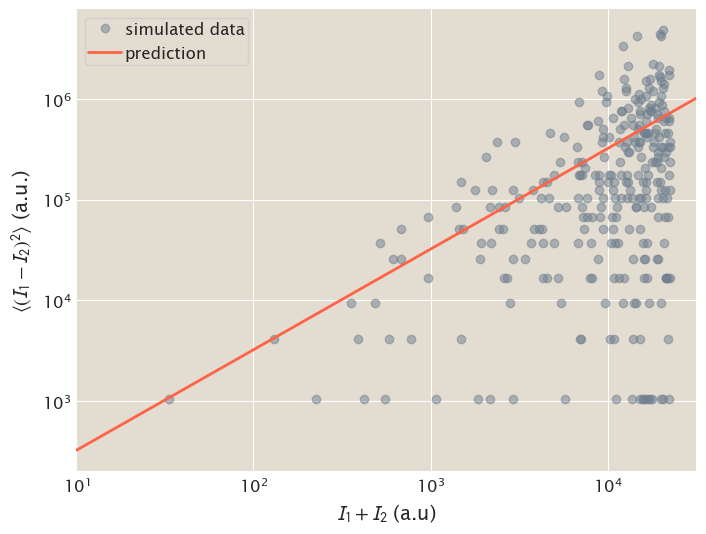

In [89]:
# Instantiate the figure and add axis labels. 
fig, ax = plt.subplots(1,1)
_ = ax.set_xlabel('$I_1 + I_2$ (a.u)')
_ = ax.set_ylabel(r'$\langle (I_1 - I_2)^2 \rangle$ (a.u.)')

# Set the scaling.
ax.set_yscale('log')
ax.set_xscale('log')

# Plot the data and the theoretical prediction.
_ = ax.plot(df['I_tot'], df['sq_diff'], 'o', color='slategray', alpha=0.5,
           label='simulated data')
_ = ax.plot(I_tot_range, prediction, '-', color='tomato', label='prediction') 

# Add a legend.
_ = ax.legend(loc='upper left')

# Set the limits of the axis. 
_ = ax.set_xlim([1E1, 1 * 10**4.5])

In [78]:
# Bin by events.
sorted_df = df.sort_values(by='I_tot')

# Choose a bin number.
bin_width = 55 
bins = np.arange(0, len(I_tot), bin_width)

# Compute the mean value for each bin
mean_Itot = [np.mean(sorted_df.iloc[bins[i-1]: bins[i]+1]['I_tot']) for i in range(1, len(bins))]
mean_sq_diff = [np.mean(sorted_df.iloc[bins[i-1]: bins[i]+1]['sq_diff']) for i in range(1, len(bins))]

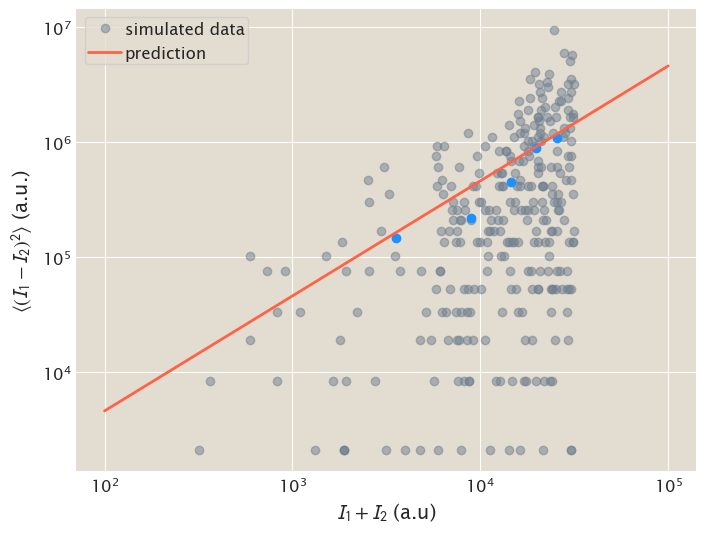

In [79]:
# Instantiate the axis and add labels
fig, ax = plt.subplots(1,1)
_ = ax.set_xlabel('$I_1 + I_2$ (a.u)')
_ = ax.set_ylabel(r'$\langle (I_1 - I_2)^2 \rangle$ (a.u.)')

# Set the scaling.
ax.set_yscale('log')
ax.set_xscale('log')

# Plot the data and the theoretical prediction.
_ = ax.plot(df['I_tot'], df['sq_diff'], 'o', color='slategray', alpha=0.5,
           label='simulated data')
_ = ax.plot(mean_Itot, mean_sq_diff, 'o', color='dodgerblue')
_ = ax.plot(I_tot_range, prediction, '-', color='tomato', label='prediction') 

# Add a legend.
_ = ax.legend(loc='upper left')

In [37]:
def (si)